# Bangkit Assigment: Lung Disease Classification with Machine Learning
This is an initial commit of the notebook, please add more things here!

## Dependencies

In [1]:
# Install dependencies

!pip install -q kaggle
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 1.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
# Import libraries

# Colab library to upload files to notebook
from google.colab import files

# Import necessary libraries for processing
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Utility
import math
import scipy.io.wavfile as wf  #wave file reader

# Feature extraction
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sklearn

# CNN
from keras import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, LeakyReLU
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.optimizers import Adam

# Results
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

## Setup kaggle API

In [3]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

## Data Preparation

### Download from kaggle

In [5]:
%%time
# Download dataset from upstream
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.68G/3.69G [01:22<00:00, 50.9MB/s]
100% 3.69G/3.69G [01:22<00:00, 48.2MB/s]
CPU times: user 431 ms, sys: 117 ms, total: 548 ms
Wall time: 1min 28s


In [6]:
%%time
# Unzip dataset into a folder
!unzip respiratory-sound-database.zip -d dataset

Archive:  respiratory-sound-database.zip
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_fi

### Data processing

In [0]:
df_no_diagnosis = pd.read_csv('dataset/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('dataset/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [8]:
# Combine diagnosis data with patient data
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [0]:
root = 'dataset/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [0]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [11]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,193,7b3,Tc,mc,AKGC417L
0,145,3b2,Ar,mc,AKGC417L
0,174,1p4,Ll,mc,AKGC417L
0,204,7p5,Tc,mc,AKGC417L
0,130,2p5,Pl,mc,AKGC417L


In [0]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})

In [13]:
w_labels = file_label_df[(file_label_df['crackles only'] != 0) | (file_label_df['wheezes only'] != 0) | (file_label_df['crackles and wheezees'] != 0)]
file_label_df.sum()

filename                 193_7b3_Tc_mc_AKGC417L145_3b2_Ar_mc_AKGC417L17...
no label                                                              3642
crackles only                                                         1864
wheezes only                                                           886
crackles and wheezees                                                  506
dtype: object

### Utility Functions

In [0]:
import math
import scipy.io.wavfile as wf
#wave file reader

#Will resample all files to the target sample rate and produce a 32bit float array
def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode = 'r')
    (sample_rate, data) = extract2FloatArr(wav,str_filename)
    
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
        
    wav.close()
    return (target_rate, data.astype(np.float32))

def resample(current_rate, data, target_rate):
    x_original = np.linspace(0,100,len(data))
    x_resampled = np.linspace(0,100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

# -> (sample_rate, data)
def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    
    if bps in [1,2,4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor)) #clamp to [0.0,1.0]        
        return (rate, data)
    
    elif bps == 3: 
        #24bpp wave
        return read24bitwave(lp_wave)
    
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))
        
#Note: This function truncates the 24 bit samples to 16 bits of precision
#Reads a wave object returned by the wave.read() method
#Returns the sample rate, as well as the audio in the form of a 32 bit float numpy array
#(sample_rate:float, audio_data: float[])
def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames,-1)
    short_output = np.empty((nFrames, 2), dtype = np.int8)
    short_output[:,:] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))  #return numpy array to save memory via array slicing

def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels()) #bytes per sample
    return (bps, lp_wave.getnchannels())

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

### Distribution of respiratory cycle lengths


longest cycle:16.163
shortest cycle:0.20000000000000284
Fraction of samples less than 5 seconds:0.9660771238040011


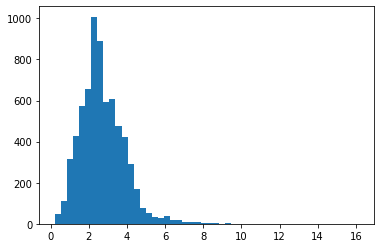

In [0]:
duration_list = []
for i in range(len(rec_annotations)):
    current = rec_annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 5
print('Fraction of samples less than {} seconds:{}'.format(threshold,
                                                           np.sum(duration_list < threshold)/len(duration_list)))

## Feature Extraction



### Feature extraction function

In [0]:
max_pad_len = 862 # to make the length of all MFCC equal

#This function takes in the path for an audio file as a string, loads it, and returns the MFCC
# of the audio
def extract_features_mfcc(file_name):
    try:
      audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
      mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
      padding_width = max_pad_len - mfccs.shape[1]
      mfccs = np.pad(mfccs, pad_width=((0, 0), (0, padding_width)), mode='constant')
      print('Before')
      print(mfccs.mean(axis=1))
      print(mfccs.var(axis=1))
      librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

### Feature extraction normalization (updated)

In [0]:
def extract_features_mfcc_normalize(file_name):
    try:
      audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
      mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
      padding_width = max_pad_len - mfccs.shape[1]
      mfccs = np.pad(mfccs, pad_width=((0, 0), (0, padding_width)), mode='constant')
      # print('After')
      mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
      # print(mfccs.mean(axis=1))
      # print(mfccs.var(axis=1))
      # librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

Before
[-4.22632207e+02  1.19029471e+02  6.13779931e+01  2.91857734e+01
  2.48751215e+01  2.56189371e+01  2.24185290e+01  1.87894190e+01
  1.57266824e+01  1.18139699e+01  8.33669762e+00  8.32043505e+00
  1.05586705e+01  1.12633263e+01  9.84463870e+00  8.60601822e+00
  7.56063184e+00  5.36257036e+00  3.24646413e+00  3.52689650e+00
  5.02260322e+00  4.47118122e+00  1.76776258e+00  2.19711039e-02
  6.98280481e-01  2.23796676e+00  3.22768661e+00  3.37222799e+00
  2.33086962e+00  3.39955900e-01 -6.40012224e-01  7.85366196e-01
  2.79032006e+00  2.65142495e+00  1.08749415e+00  6.49820646e-01
  1.36212317e+00  1.31270356e+00  4.96942646e-01  6.37856175e-01]
[476.40025415 365.62559658  91.85342668  38.48692571  27.36686788
  24.966273    18.98068072  17.28586304  25.70675125  25.05203129
  19.35992893  14.78184795  12.4148707   11.25783519  12.89155306
  12.88338157  12.96134613  12.56106378  11.56469493  10.18795145
   8.93283593   8.93308959   9.08056195  13.16143835  14.87923322
   9.2340084

array([[-4.17120839e+02, -2.67332184e+02, -2.56847367e+02, ...,
        -4.07911734e+02, -4.05363507e+02, -3.87951534e+02],
       [ 1.00320021e+02,  1.21262227e+02,  1.24895044e+02, ...,
         1.37134930e+02,  1.39240727e+02,  1.52637883e+02],
       [ 2.47609115e+01,  1.18193154e+01,  1.43672083e+01, ...,
         7.26431729e+01,  7.27426581e+01,  7.05341272e+01],
       ...,
       [-3.59022535e-02,  8.98475879e-01,  1.32787033e+00, ...,
        -1.21685550e+00,  2.39631475e+00,  5.03666843e+00],
       [-1.89748386e-01,  1.39830555e+00,  2.07936555e+00, ...,
        -4.96637854e-01,  3.83797342e+00,  5.83673004e+00],
       [-4.21368316e-01,  6.64737470e-01,  1.13707794e+00, ...,
         6.54471661e-01,  4.84157895e+00,  5.85167029e+00]])

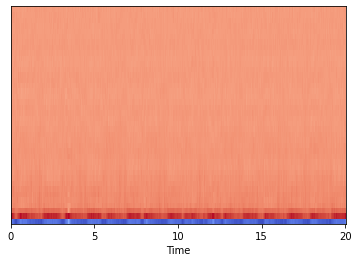

In [43]:
extract_features_mfcc(filepaths[0])

After
[-2.26681267e-15  1.48373193e-16 -2.72017521e-16  1.15401372e-16
 -6.65618630e-16 -2.47288655e-16 -5.35792086e-16 -4.12147759e-16
  1.89587969e-16  4.53362534e-17 -1.11279895e-16  0.00000000e+00
 -1.00976201e-16  4.94577310e-17 -1.11279895e-16 -9.06725069e-17
 -4.12147759e-17 -9.06725069e-17  4.73969922e-17 -3.29718207e-17
 -2.14316834e-16  6.59436414e-17  1.23644328e-17  8.24295517e-18
 -3.09110819e-17 -3.96692218e-17  6.59436414e-17 -1.56616148e-16
  8.24295517e-18  0.00000000e+00  2.16377573e-17  4.12147759e-17
  1.64859103e-17 -1.07158417e-16  8.65510293e-17  3.29718207e-17
 -6.59436414e-17 -7.21258577e-17  8.24295517e-18  0.00000000e+00]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


array([[ 2.52507010e-01,  7.11517406e+00,  7.59554291e+00, ...,
         6.74428268e-01,  7.91177027e-01,  1.58891817e+00],
       [-9.78459238e-01,  1.16767778e-01,  3.06755333e-01, ...,
         9.46871943e-01,  1.05700002e+00,  1.75763906e+00],
       [-3.82063937e+00, -5.17097013e+00, -4.90512207e+00, ...,
         1.17541288e+00,  1.18579320e+00,  9.55354299e-01],
       ...,
       [-5.28419486e-01, -1.62305380e-01,  5.94273970e-03, ...,
        -9.91148253e-01,  4.24587569e-01,  1.45914809e+00],
       [-2.39851865e-01,  3.14833839e-01,  5.52718861e-01, ...,
        -3.47044195e-01,  1.16697674e+00,  1.86511533e+00],
       [-3.77413870e-01,  9.57811459e-03,  1.77878457e-01, ...,
         5.92028865e-03,  1.49783478e+00,  1.85774194e+00]])

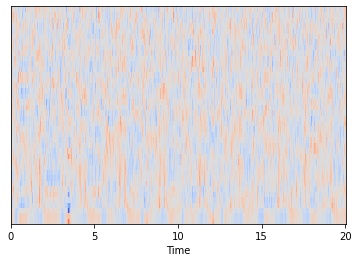

In [44]:
extract_features_mfcc_normalize(filepaths[0])

In [56]:
filenames = [f for f in listdir(root) if (isfile(join(root, f)) and f.endswith('.wav'))] 
filepaths = [join(root, f) for f in filenames] # full paths of files
features = []

# Iterate through each sound file and extract the features
for file_name in filepaths:
    # data = extract_features_mfcc(file_name)
    data = extract_features_mfcc_normalize(file_name)
    if data is not None:
      # print(data)
      features.append(data)

print('Finished feature extraction using MFCC from ', len(features), ' files')

Finished feature extraction using MFCC from  920  files


### Data preparation

In [0]:
# patient IDs corresponding to each file
p_id_in_file = [] 
for name in filenames:
    p_id_in_file.append(int(name[:3]))

# patient diagnosis file - Should use the file in the beginning of the notebook but it returns error
p_diag = pd.read_csv('dataset/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv',header=None) 

p_id_in_file = np.array(p_id_in_file) 

# labels for audio files
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) 

# Remove a very rare disease, it returns an error if we're not removing it
labels_fix = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels_fix)
oh_labels = to_categorical(i_labels) 


In [0]:
# convert to numpy array
features = np.array(features) 

# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma' )| (labels == 'LRTI') )[0], axis=0) 

# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1))

In [0]:
# train test split = This is the data for training the model
train_features, test_features, train_labels, test_labels = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

## Build the Model Using CNN


### Download training data from kaggle to speed up training (If skipping previous steps)

In [0]:
%%time
# Download processed feature extraction
!kaggle datasets download -d risyadhasbullah/bangkit-features
!unzip bangkit-features.zip -d cached
train_features = np.load('cached/train_features.npy')
test_features = np.load('cached/test_features.npy')
train_labels = np.load('cached/train_labels.npy')
test_labels = np.load('cached/test_labels.npy')
oh_labels = np.load('cached/oh_labels.npy')

 99% 226M/229M [00:01<00:00, 180MB/s]
100% 229M/229M [00:01<00:00, 169MB/s]
Archive:  bangkit-features.zip
  inflating: cached/oh_labels.npy    
  inflating: cached/test_features.npy  
  inflating: cached/test_labels.npy  
  inflating: cached/train_features.npy  
  inflating: cached/train_labels.npy  
CPU times: user 97.9 ms, sys: 203 ms, total: 301 ms
Wall time: 8.17 s


### CNN

In [0]:
# set data size
num_rows = 20
num_columns = 862
num_channels = 1
num_labels = oh_labels.shape[1]
filter_size = 2

In [0]:
# Construct model 
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(LeakyReLU(alpha = 0.01))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(LeakyReLU(alpha = 0.01))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(LeakyReLU(alpha = 0.01))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [64]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(test_features, test_labels, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 19, 861, 64)       320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 19, 861, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 430, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 430, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 429, 128)       32896     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 429, 128)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 214, 128)      

In [0]:
# hyperparameters
num_epochs = 100
num_batch_size = 128

In [65]:
# train model
callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(train_features, train_labels, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(test_features, test_labels), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

print('hyperparameters:')
print('epochs', num_epochs)
print('batch', num_batch_size)


# Evaluating the model on the training and testing set
print('result:')
score = model.evaluate(train_features, train_labels, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model.evaluate(test_features, test_labels, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Train on 733 samples, validate on 184 samples
Epoch 1/100
733/733 [==============================] - 17s 23ms/step - loss: 0.9762 - accuracy: 0.7340 - val_loss: 0.6078 - val_accuracy: 0.8641

Epoch 00001: val_accuracy improved from -inf to 0.86413, saving model to mymodel2_01.h5
Epoch 2/100
733/733 [==============================] - 17s 23ms/step - loss: 0.7258 - accuracy: 0.8649 - val_loss: 0.6087 - val_accuracy: 0.8641

Epoch 00002: val_accuracy did not improve from 0.86413
Epoch 3/100
733/733 [==============================] - 16s 22ms/step - loss: 0.6128 - accuracy: 0.8649 - val_loss: 0.8342 - val_accuracy: 0.8641

Epoch 00003: val_accuracy did not improve from 0.86413
Epoch 4/100
733/733 [==============================] - 18s 24ms/step - loss: 0.6182 - accuracy: 0.8649 - val_loss: 0.6880 - val_accuracy: 0.8641

Epoch 00004: val_accuracy did not improve from 0.86413
Epoch 5/100
733/733 [==============================] - 18s 24ms/step - loss: 0.5896 - accuracy: 0.8649 - val_loss: 0.

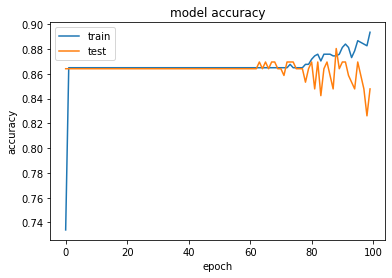

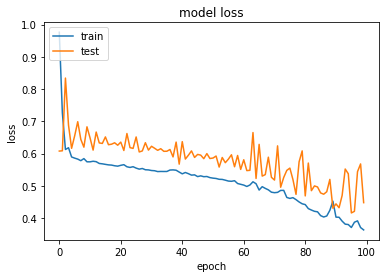

In [66]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
# Evaluating the model on the training and testing set
score = model.evaluate(train_features, train_labels, verbose=0)
print("Training Accuracy: ", score[1])
print("Training Loss: ", score[0])

score = model.evaluate(test_features, test_labels, verbose=0)
print("Testing Accuracy: ", score[1])
print("Testing Loss: ", score[0])

Training Accuracy:  0.8990450501441956
Training Loss:  0.39421085417677243
Testing Accuracy:  0.8478260636329651
Testing Loss:  0.4479368199472842


In [0]:
preds = model.predict(test_features) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(test_labels, axis=1) # true classes

n_classes=6 # number of classes

In [0]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

In [70]:
print('Classification Report')
print(classification_report(y_testclass, classpreds, target_names=c_names))


print('Confusion Matrix')
print(confusion_matrix(y_testclass, classpreds))

Classification Report
                precision    recall  f1-score   support

Bronchiectasis       0.00      0.00      0.00         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.91      0.95      0.93       159
       Healthy       0.33      0.29      0.31         7
     Pneumonia       0.27      0.43      0.33         7
          URTI       0.00      0.00      0.00         5

      accuracy                           0.85       184
     macro avg       0.25      0.28      0.26       184
  weighted avg       0.81      0.85      0.83       184

Confusion Matrix
[[  0   0   3   0   0   0]
 [  0   0   1   2   0   0]
 [  0   0 151   0   7   1]
 [  0   0   4   2   1   0]
 [  0   0   4   0   3   0]
 [  0   0   3   2   0   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Saving the model

In [0]:
model.save('model.h5')
files.download('model.h5')